In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
df1 = pd.read_csv(r"C:\Users\Suwani Gunasekara\OneDrive\Documents\Sem 7 ML\Mid term\teamrank_GP_Poisson_1.csv")
df1.head()

,home_team,away_team,home_goals,away_goals,Ranking_home_team,Ranking_away_team,Total_Score_home_team,Total_Score_away_team,Total_count_home_team,Total_count_away_team,Year,tournament,HomeTeamRank_Difference,AwayTeamRank_Difference
0,Egypt,Czechoslovakia,2,0,21.0,18.0,45.0,47.0,0,0,1992,Friendly,3.0,-3.0
1,DR Congo,Ivory Coast,2,0,0.0,0.0,0.0,0.0,0,0,1992,Friendly,0.0,0.0
2,Guyana,Barbados,0,2,128.0,114.0,4.0,7.0,0,0,1992,Friendly,14.0,-14.0
3,Egypt,Norway,0,0,21.0,14.0,45.0,49.0,0,0,1992,Friendly,7.0,-7.0
4,Cameroon,Morocco,1,0,22.0,41.0,43.0,32.0,0,0,1992,African Cup of Nations,-19.0,19.0


In [7]:
# get the games played in FIFA world cup
dfFIFA = df1.loc[df1.tournament == 'FIFA World Cup'].reset_index()

In [8]:
# split the dataset in to train and test
traindf, testdf = train_test_split(dfFIFA, test_size=0.33, random_state=42)

In [11]:
goal_model_data = pd.concat([traindf[['home_team','away_team','home_goals','Total_Score_home_team',
                                       'Total_count_home_team','HomeTeamRank_Difference','tournament']].assign(home=1).rename(
            columns={'home_team':'team', 'away_team':'opponent','home_goals':'goals',
                     'Total_Score_home_team':'total_score','Total_count_home_team':'total_count','HomeTeamRank_Difference':'rank_difference','tournament':'tournament'}),
           traindf[['away_team','home_team','away_goals','Total_Score_away_team','Total_count_away_team',
                     'AwayTeamRank_Difference']].assign(home=0).rename(
            columns={'away_team':'team', 'home_team':'opponent','away_goals':'goals',
                    'Total_Score_away_team':'total_score','Total_count_away_team':'total_count',
                     'AwayTeamRank_Difference':'rank_difference','tournament':'tournament'})])

In [12]:
poisson_model_FIFA= smf.glm(formula="goals ~ rank_difference", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
poisson_model_FIFA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  584
Model:                            GLM   Df Residuals:                      582
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -816.45
Date:                Mon, 16 Aug 2021   Deviance:                       625.06
Time:                        07:43:46   Pearson chi2:                     570.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1947      0.038      5.092      0.000       0.120       0.270
rank_difference    -0.0131      0.002     -7.792      0.000      -0.016      -0.010
===================================================================================
"""

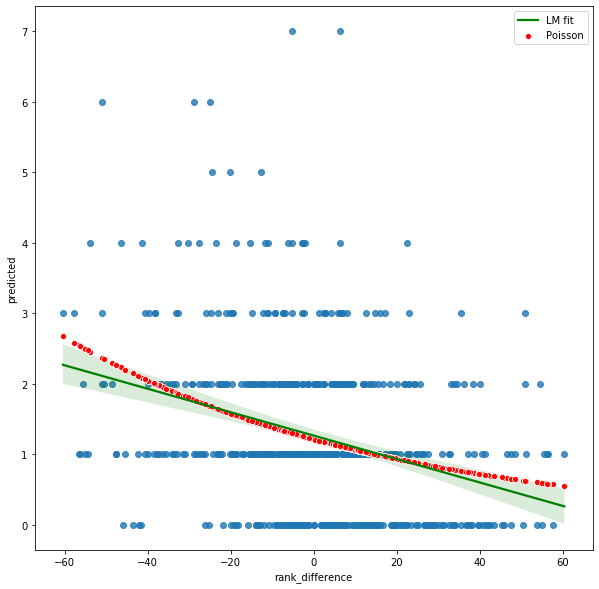

In [16]:
goal_model_data['predicted'] = poisson_model_FIFA.fittedvalues
plt.subplots(figsize = (10,10))
sns.regplot('rank_difference','goals',data =goal_model_data, fit_reg= True ,
           line_kws = {'color':'green',
                      'label': 'LM fit'})
sns.scatterplot('rank_difference','predicted',data = goal_model_data, color = 'red', label = 'Poisson')

In [32]:
def getPrediction(model,ht_rd,at_rd):
    predictdict = {}
    home_team_goals = round(model.predict(pd.DataFrame(data = {'rank_difference': ht_rd},index = [1])).values[0])
    away_team_goals = round(model.predict(pd.DataFrame(data = {'rank_difference': at_rd},index = [1])).values[0])

    if home_team_goals > away_team_goals:
        predictdict['pred'] = "HW"
    elif home_team_goals < away_team_goals:
        predictdict['pred'] = "AW"
    else:
        predictdict['pred'] = "D"
    return predictdict

In [33]:
wl_ = []
for index,row in testdf.iterrows():
    alldictpredict = {}
    
    home_team = row['home_team']
    away_team = row['away_team']
    ht_rd     = row['HomeTeamRank_Difference']
    at_rd     = row['AwayTeamRank_Difference']
    pred = getPrediction(poisson_model_FIFA,ht_rd,at_rd)
    
    
    alldictpredict['home_team'] = row['home_team']
    alldictpredict['away_team'] = row['away_team']
    #alldict['Goals'] = row['WonGoals']
    alldictpredict['pred'] = pred['pred']
    if row['home_goals']>row['away_goals']:
        alldictpredict['actual'] = "HW"
    elif row['home_goals']<row['away_goals']:
        alldictpredict['actual'] = "AW"
    else:
        alldictpredict['actual'] = "D"
    #alldictpredict['home_goals'] = row['home_goals']
    #alldictpredict['away_goals'] = row['away_goals']
    #print(alldict)
    wl_.append(alldictpredict)
    df_p = pd.DataFrame(wl_)
    
    #print(year,month,home_team,away_team) 

In [34]:
df_p.head()

,home_team,away_team,pred,actual
0,Brazil,Costa Rica,HW,HW
1,Netherlands,South Korea,D,HW
2,Nigeria,South Korea,AW,D
3,Germany,Spain,D,AW
4,Australia,Netherlands,AW,AW


In [102]:
df_p.shape

(144, 4)

In [101]:
type(df_p.actual)
type(df_p.pred)

pandas.core.series.Series

In [66]:
y_test = df_p.actual
y_pred = df_p.pred
conf_matrix = confusion_matrix(y_actu, y_pred)
conf_matrix

array([[17, 31,  3],
       [ 8, 22,  5],
       [ 5, 31, 22]], dtype=int64)

In [67]:
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion = df_confusion.drop(['All'], axis = 1)
df_confusion = df_confusion.drop(['All'], axis = 0)
df_confusion.head()

Predicted,AW,D,HW
Actual,,,
AW,17,31,3
D,8,22,5
HW,5,31,22


In [68]:
'''
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_confusion)
'''

"\ndef plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):\n    plt.matshow(df_confusion, cmap=cmap) # imshow\n    #plt.title(title)\n    plt.colorbar()\n    tick_marks = np.arange(len(df_confusion.columns))\n    plt.xticks(tick_marks, df_confusion.columns, rotation=45)\n    plt.yticks(tick_marks, df_confusion.index)\n    #plt.tight_layout()\n    plt.ylabel(df_confusion.index.name)\n    plt.xlabel(df_confusion.columns.name)\n\nplot_confusion_matrix(df_confusion)\n"

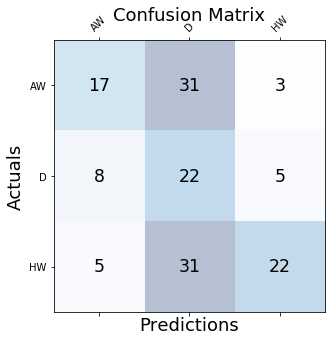

In [69]:

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
tick_marks = np.arange(len(df_confusion.columns))
plt.xticks(tick_marks, df_confusion.columns, rotation=45)
plt.yticks(tick_marks, df_confusion.index)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [71]:
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['AW', 'D', 'HW']))


Accuracy: 0.42

Micro Precision: 0.42
Micro Recall: 0.42
Micro F1-score: 0.42

Macro Precision: 0.52
Macro Recall: 0.45
Macro F1-score: 0.43

Weighted Precision: 0.56
Weighted Recall: 0.42
Weighted F1-score: 0.44

Classification Report

              precision    recall  f1-score   support

          AW       0.57      0.33      0.42        51
           D       0.26      0.63      0.37        35
          HW       0.73      0.38      0.50        58

    accuracy                           0.42       144
   macro avg       0.52      0.45      0.43       144
weighted avg       0.56      0.42      0.44       144



In [95]:
#poisson_model_FIFA_2= smf.glm(formula="goals ~ rank_difference+total_count", data=goal_model_data, 
                        #family=sm.families.Poisson()).fit()
#poisson_model_FIFA_2.summary()

In [92]:
# get the games played in FIFA world cup
df2000 = df1.loc[df1.Year >= 2000].reset_index()
# split the dataset in to train and test
traindf2000, testdf2000 = train_test_split(df2000, test_size=0.33, random_state=42)
goal_model_data_2000 = pd.concat([traindf2000[['home_team','away_team','home_goals','Total_Score_home_team',
                                       'Total_count_home_team','HomeTeamRank_Difference','tournament']].assign(home=1).rename(
            columns={'home_team':'team', 'away_team':'opponent','home_goals':'goals',
                     'Total_Score_home_team':'total_score','Total_count_home_team':'total_count','HomeTeamRank_Difference':'rank_difference','tournament':'tournament'}),
           traindf2000[['away_team','home_team','away_goals','Total_Score_away_team','Total_count_away_team',
                     'AwayTeamRank_Difference']].assign(home=0).rename(
            columns={'away_team':'team', 'home_team':'opponent','away_goals':'goals',
                    'Total_Score_away_team':'total_score','Total_count_away_team':'total_count',
                     'AwayTeamRank_Difference':'rank_difference','tournament':'tournament'})])

In [80]:
poisson_model_2000= smf.glm(formula="goals ~ rank_difference", data=goal_model_data_2000, 
                        family=sm.families.Poisson()).fit()
poisson_model_2000.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                26288
Model:                            GLM   Df Residuals:                    26286
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -41974.
Date:                Mon, 16 Aug 2021   Deviance:                       39980.
Time:                        11:17:18   Pearson chi2:                 4.53e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2755      0.005     50.140      0.000       0.265       0.286
rank_difference    -0.0049   7.99e-05    -61.714      0.000      -0.005      -0.005
===================================================================================
"""

In [93]:
wl_2000 = []
for index,row in testdf2000.iterrows():
    alldictpredict = {}
    
    home_team = row['home_team']
    away_team = row['away_team']
    ht_rd     = row['HomeTeamRank_Difference']
    at_rd     = row['AwayTeamRank_Difference']
    pred = getPrediction(poisson_model_2000,ht_rd,at_rd)
    
    
    alldictpredict['home_team'] = row['home_team']
    alldictpredict['away_team'] = row['away_team']
    #alldict['Goals'] = row['WonGoals']
    alldictpredict['pred'] = pred['pred']
    if row['home_goals']>row['away_goals']:
        alldictpredict['actual'] = "HW"
    elif row['home_goals']<row['away_goals']:
        alldictpredict['actual'] = "AW"
    else:
        alldictpredict['actual'] = "D"
    #alldictpredict['home_goals'] = row['home_goals']
    #alldictpredict['away_goals'] = row['away_goals']
    #print(alldict)
    wl_2000.append(alldictpredict)
    df_p_2000 = pd.DataFrame(wl_2000)
    
    #print(year,month,home_team,away_team) 

In [94]:
df_p_2000.head()

,home_team,away_team,pred,actual
0,Colombia,Peru,D,D
1,Burma,Hong Kong,HW,HW
2,Cyprus,Estonia,D,D
3,North Macedonia,Austria,AW,AW
4,Solomon Islands,Tahiti,D,AW


In [99]:
type(df_p_2000.actual)

pandas.core.series.Series

In [100]:
type(df_p_2000.pred)

pandas.core.series.Series

In [98]:
confusion_matrix(y_actu, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [144, 6474]

In [82]:
y_test = df_p_2000.actual
y_pred = df_p_2000.pred
conf_matrix = confusion_matrix(y_actu, y_pred)

df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion = df_confusion.drop(['All'], axis = 1)
df_confusion = df_confusion.drop(['All'], axis = 0)
df_confusion.head()


fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
tick_marks = np.arange(len(df_confusion.columns))
plt.xticks(tick_marks, df_confusion.columns, rotation=45)
plt.yticks(tick_marks, df_confusion.index)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['AW', 'D', 'HW']))

ValueError: Found input variables with inconsistent numbers of samples: [144, 6474]